<h1>Trabalho 3 - Extração de atributos e Classificação</h1>

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path
import cv2
import scipy.misc

In [10]:
dados = np.loadtxt('ocr_car_numbers_rotulado.txt')


<h4>Função que seleciona uma linha da base e retorna uma imagem 35*35:</h4>

In [11]:
def getImage(data, row):
    image = data[row, :-1] #seleciona a lilha e apaga o útima coluna
    image.shape = (35, 35) #converte para duas dimensões
    image[image==1]=255
    image = np.uint8(image)
    return image

<h4>Exibindo os cinco primeiros números:</h4>

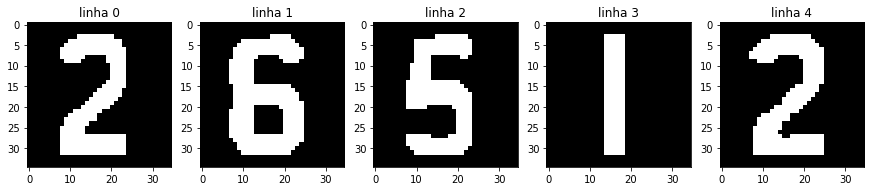

In [12]:
linhas = 5

imgs = [getImage(dados, i) for i in range(len(dados))]

plt.figure(figsize=(15,10))
for i in range(linhas):
    plt.subplot(1,linhas,i+1)
    plt.subplot(1,linhas,i+1).set_title('linha ' + str(i))
    plt.imshow(imgs[i], 'gray')


<h2>Extrator 01 - Código de Cadeia - Seguidores de fronteiras</h2>
<p>Usando dilatação morfológica para retirar o contorno da imagem, para obter o contorno primeiro é feito a dilatação depois e feito a subtração da imagem dilatada pela imagem original resultando no seu contorno, que será usado para obtenção das cordenadas do contorno mais externo<p>

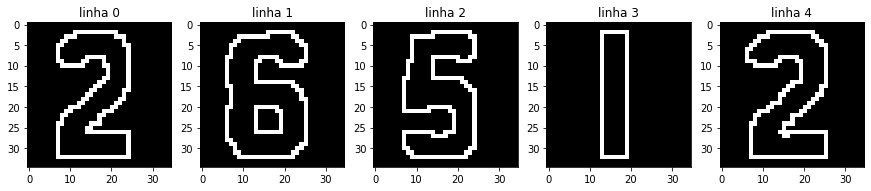

In [13]:
#canny = cv2.Canny(img,100,300)
#edges = canny.copy()

kernel = np.ones((3,3), np.uint8)
edges = [cv2.dilate(img, kernel, iterations=1) - img for img in imgs] #array de bordas do array de imagens
 
plt.figure(figsize=(15,10))
for i in range(linhas):
    plt.subplot(1,linhas,i+1)
    plt.subplot(1,linhas,i+1).set_title('linha ' + str(i))
    plt.imshow(edges[i], 'gray')


<p>Exibindo o contorno mas externo sobre a imagem original e o contorno isolado dos cinco primeiros números, o parâmetro cv2.RETR_EXTERNAL da função cv2.findContours retorna as cordenadas do contorno mais externo</p>

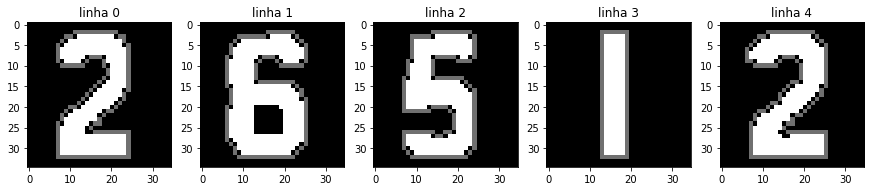

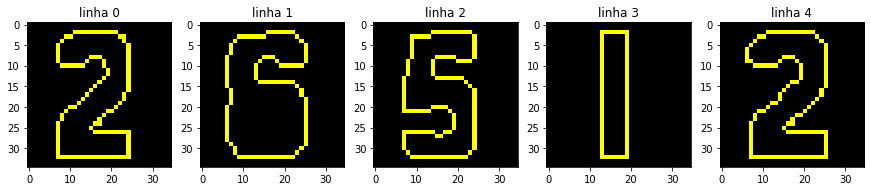

In [14]:
newImgs = []
n_contours = []

for i in range(len(edges)):
    contours, hierarchy = cv2.findContours(edges[i],cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    n_contours.append(contours)

    maior = 0 #descobrir qual conjunto de contornos tem mais pontos
    for sizet in range(len(contours)):
        if (len(contours[sizet])>maior):
            maior = sizet

    newImg = np.zeros([35,35,3])
    newImg = np.uint8(newImg)

    for ind_contour in range(len(contours)):

        imgs[i] = cv2.polylines(imgs[i][:],contours,True,(112,255,255),1)#desenhando o poligono de acordo com os pontos
        newImg = cv2.polylines(newImg,contours,True,(0,255,255),1)#desenhando o poligono de acordo com os pontos
        
    newImgs.append(newImg)
    
plt.figure(figsize=(15,10))
for i in range(linhas):
    plt.subplot(1,linhas,i+1)
    plt.subplot(1,linhas,i+1).set_title('linha ' + str(i))
    plt.imshow(imgs[i], 'gray')
    
plt.figure(figsize=(15,10))
for i in range(linhas):
    newImgs[i] = cv2.cvtColor(newImgs[i], cv2.COLOR_BGR2RGB)
    plt.subplot(1,linhas,i+1)
    plt.subplot(1,linhas,i+1).set_title('linha ' + str(i))
    plt.imshow(newImgs[i], 'gray')

<p>As duas funções a seguir gerar o cógido da cadeia, a primeira retorna uma direção para cada duas cordenadas e a segunda recebe como parametro as cordenadas do contorno e retorna o array da cadeia<p>

In [15]:
def getChainCode(x1, y1, x2, y2): 
    dx = x2 - x1 
    dy = y2 - y1 
    
    if dx>0: #Significa que as posições podem ser (5,4,3)
        if dy <0 :
            code = 5
        elif dy==0:
            code = 4
        else:
            code = 3

    elif dx==0: # Significa que as posicoes podem ser (6,2)
        if dy<0:
            code = 6
        elif dy>0:
            code = 2
        else:
            code=8
    else: #Significa que as posicoes podem ser (7,0,1)
        if dy<0:
            code = 7
        elif dy==0:
            code = 0
        else:
            code = 1

    return code 

In [16]:
def generateChainCode(ListOfPoints): 
    chainCode = [] 
    textChain = " "
    for i in range(len(ListOfPoints)):
        a = ListOfPoints[i][0]
        #print("valor de A = ",a[0],a[1]) 
        if i != len(ListOfPoints)-1:
            b = ListOfPoints[i + 1][0]
            #print("valor de B = ",b[0],b[1])
        else :
            b = ListOfPoints[0][0] 
        chainCode.append(getChainCode(a[0], a[1], b[0], b[1]))
        textChain = textChain + str(getChainCode(a[0], a[1], b[0], b[1]))
        textChainT = str(getChainCode(a[0], a[1], b[0], b[1]))
        #DESCOMENTAR A LINHA ABAIXO PARA MOSTRAR O CODIGO DE CADA PONTO
        #cv2.putText(edges,textChainT, (a[0],a[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(255,255,255),1,cv2.LINE_AA)
    return chainCode,textChain 

<p>Função responsável por normalizar um conjunto de valores, ela recebe uma lista de valores e um valor e faz a normalização por esse valor retornado uma nova lista</p>

In [17]:
def box(signal, smaller):
    
    index = 0
    newSignal = []
    prop = len(signal)/smaller
    d = prop
    
    while len(newSignal) < smaller:
        
        newSignal.append(signal[index])
        i, d = divmod(d, 1) #separa a pater inteira da parte decimal
        index += int(i) #adiciona a parte inteira ao indice
        d += prop #adiciona ao resto a proporcao        
        
    return newSignal   


<p>Gerando uma lista de cadeias pra cada número normalizada que será usado como o dataset</p>
<p>Depois é plotado a cadeira dos primeiros cinco números</p>

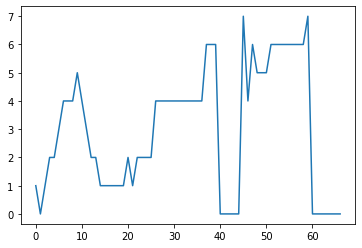

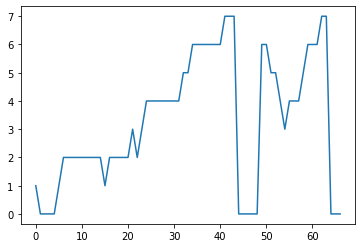

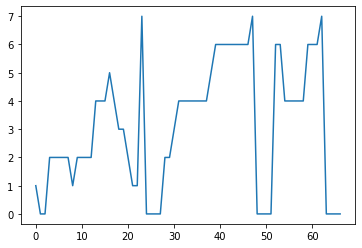

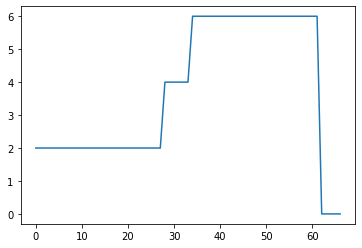

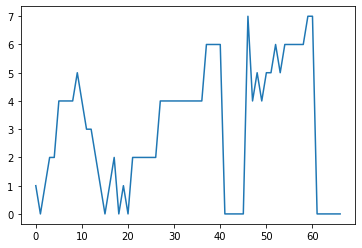

In [18]:
chainCodes = []

for contours in n_contours:
    chainCode,tsx = generateChainCode(contours[0])
    chainCodes.append(chainCode)
    #print("chain code ",ind_contour," = ", tsx)
    #print("sum ",ind_contour," = ",sum(chainCode))
    #print("Quantidade de pontos =",len(contours[ind_contour]))
    
smaller = min([len(chainCode) for chainCode in chainCodes]) #pega o comprimento da menor cadeia
chainCodes = [box(chainCode, smaller) for chainCode in chainCodes] #faz a normalização das cadeias

chainCodes = np.array(chainCodes)
    
for i in range(5):
    plt.plot(chainCodes[i])
    plt.show()


In [19]:
def normalizeImage(v):
  v = (v - v.min()) / (v.max() - v.min())
  result = (v * 255).astype(np.uint8)
  return result

In [147]:
imgs = [getImage(dados, i) for i in range(len(dados))]
imgs = [normalizeImage(img) for img in imgs]



<h2>Extrator 2 - Assinatura</h2>
<p>A função centroid retorna o centroide da uma imagem</p>

In [21]:
def centroid(img):
    ret,thresh = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
    height, width = thresh.shape[:2]

    mass = 0
    Xcm  = 0.0
    Ycm  = 0.0

    for i in range(width) :
        for j in range(height) :
            if not thresh[j][i] :
                mass += 1
                Xcm  += i
                Ycm  += j

    return  [Ycm/mass, Xcm/mass]

<p>A função a signature recebe uma imagem calcula seu contorno com a função cv2.findContours e o centroide com a função centroide e então calcula a distância de cada ponto do contorno ao centroide resultando na assinatura da imagem</p>

In [22]:
def signature(image):
    sign = []
    contours, _ = cv2.findContours(image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    center = centroid(image)
    for i in range(len(contours[0])):
        point = contours[0][i][0]
        dist = np.linalg.norm(point-center)
        sign.append(dist)
    
    return sign

<p>Criando do datasete de assinaturas e plotando a assinatura dos cinco primeiros números:</p>

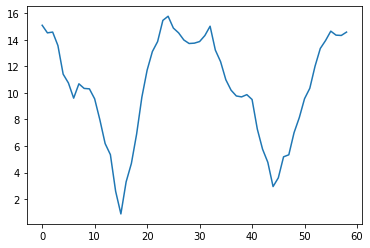

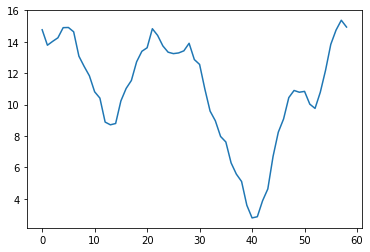

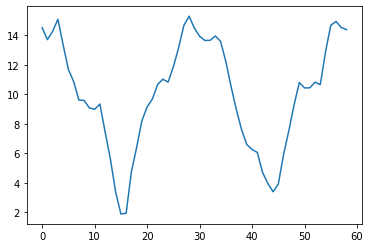

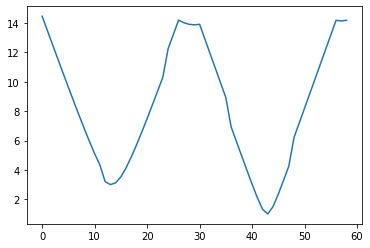

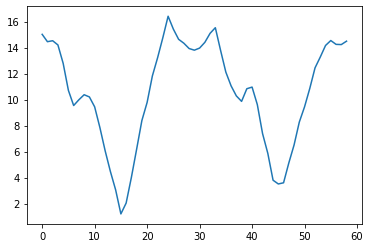

In [23]:
signatures = [signature(img) for img in imgs]

smaller = min([len(signature) for signature in signatures]) #pega o comprimento da menor cadeia
signatures = [box(signature, smaller) for signature in signatures] #faz a normalização das cadeias

signatures = np.array(signatures)

for i in range(5):
    plt.plot(signatures[i])
    plt.show()

<h2>Extartor 2 - Convex Hull</h2>
<p>Para se obter os pontos mais externos, primeiro foi calculada as cordenadas dos contornos da imagem através da função cv2.findContours com o parâmtro cv2.RETR_TREE e então aplicada a função cv2.convexHull que retorna esses pontos</p>
<p>É então exibito um contorno composto por esses pontos dos primeiros cinco números</p>

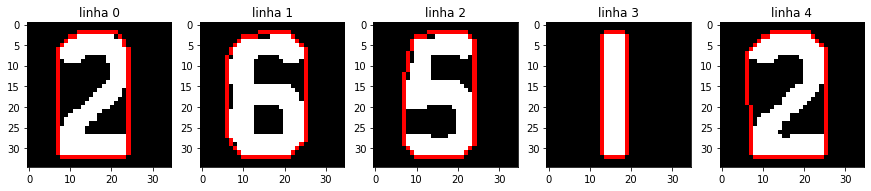

In [24]:
convexHulls = []

for img in imgs:
    blur = cv2.blur(img, (3, 3))
    ret, thresh = cv2.threshold(blur, 50, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
    
    hull = []
    for i in range(len(contours)):
        hull.append(cv2.convexHull(contours[i], False))
    
    convexHulls.append(hull)
    
drawings = []
for l in range(5):        
    drawing = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)
    drawing[:,:,0] = drawing[:,:,1] = drawing[:,:,2] = imgs[l]
    
    for i in range(len(contours)):
        cv2.drawContours(drawing, convexHulls[l], i, (0, 0, 255), 1, 8)
        
    drawings.append(drawing)
    
plt.figure(figsize=(15,10))
for i in range(5):
    drawings[i] = cv2.cvtColor(drawings[i], cv2.COLOR_BGR2RGB)
    plt.subplot(1,linhas,i+1)
    plt.subplot(1,linhas,i+1).set_title('linha ' + str(i))
    plt.imshow(drawings[i], 'gray')
    
    

<p>É então montada um dataset com esses com a cadeia de numeros...?</p>

In [25]:
hulls = []

for points in convexHulls:
    hull,tsx = generateChainCode(points[0])
    hulls.append(hull)


smaller = max([len(hull) for hull in hulls]) #pega o comprimento da menor cadeia
hulls = [box(hull, smaller) for hull in hulls] #faz a normalização das cadeias

hulls = np.array(hulls)



In [148]:
from skimage.feature import greycomatrix, greycoprops
from skimage.feature import local_binary_pattern

def LBP_FE(image):
        lbp_image = local_binary_pattern(image, 256, 1, "uniform")
        return np.histogram(lbp_image.ravel(), bins=256)

def HU_FE(image):
        moments = cv2.moments(image.astype(np.float64))
        return np.asarray( cv2.HuMoments(moments).flatten())

def GLCM_FE(image):
        glcm = greycomatrix(image, [1], [0], 256, symmetric=True, normed=True)
        xs = []
        xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
        xs.append(greycoprops(glcm, 'correlation')[0, 0])
        xs.append(greycoprops(glcm, 'homogeneity')[0, 0])
        xs.append(greycoprops(glcm, 'ASM')[0, 0])
        xs.append(greycoprops(glcm, 'energy')[0, 0])
        xs.append(greycoprops(glcm, 'correlation')[0, 0])
        return np.asarray(xs);


In [29]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = chainCodes
y = dados[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(np.unique(y_train,return_counts=True))
print(np.unique(y_test,return_counts=True))

(2514, 67) (2514,)
(838, 67) (838,)
(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([217, 292, 245, 261, 301, 252, 286, 193, 232, 235], dtype=int64))
(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([ 91, 105,  68,  87, 112,  74,  77,  81,  81,  62], dtype=int64))


In [30]:
model = KNeighborsClassifier(10)
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(y_test, pred)

print("Accuracy: "+str(acc))

Accuracy: 0.9236276849642004


<h2>Classificador 1 - Rede Neural</h2>
<h4>Rede Neural com dataset do chainCodes</h4>

In [154]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import confusion_matrix


In [155]:
from sklearn.model_selection import train_test_split
X = chainCodes
Y = dados[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=84)

In [156]:
from keras.utils.np_utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [161]:
model = Sequential()
model.add(Dense(512, input_dim=67, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #Otimização do modelo

In [162]:
h = model.fit(X_train, y_train_cat, epochs=10, verbose=1, validation_split=0.1) #validation_data=(X_test, y_test_cat)

Epoch 1/10
71/71 [==============================] - 1s 11ms/step - loss: 0.6526 - accuracy: 0.7754 - val_loss: 0.1763 - val_accuracy: 0.9246
Epoch 2/10
71/71 [==============================] - 1s 9ms/step - loss: 0.2061 - accuracy: 0.9032 - val_loss: 0.1395 - val_accuracy: 0.9167
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.1839 - accuracy: 0.9094 - val_loss: 0.1384 - val_accuracy: 0.9206
Epoch 4/10
71/71 [==============================] - 1s 8ms/step - loss: 0.1459 - accuracy: 0.9284 - val_loss: 0.1553 - val_accuracy: 0.9167
Epoch 5/10
71/71 [==============================] - 1s 8ms/step - loss: 0.1411 - accuracy: 0.9248 - val_loss: 0.1047 - val_accuracy: 0.9444
Epoch 6/10
71/71 [==============================] - 1s 9ms/step - loss: 0.1390 - accuracy: 0.9262 - val_loss: 0.1091 - val_accuracy: 0.9444
Epoch 7/10
71/71 [==============================] - 1s 9ms/step - loss: 0.1388 - accuracy: 0.9275 - val_loss: 0.1279 - val_accuracy: 0.9048
Epoch 8/10
71/71 [=

In [163]:
results = model.evaluate(X_test, y_test_cat)
print('Train: ', results[1])

27/27 [==============================] - 0s 4ms/step - loss: 0.1487 - accuracy: 0.9403
Train:  0.940334141254425


In [164]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 512)               34816     
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_91 (Dense)            (None, 512)               262656    
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_92 (Dense)            (None, 10)                5130      
                                                                 
Total params: 302,602
Trainable params: 302,602
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 0, 'Epochs')

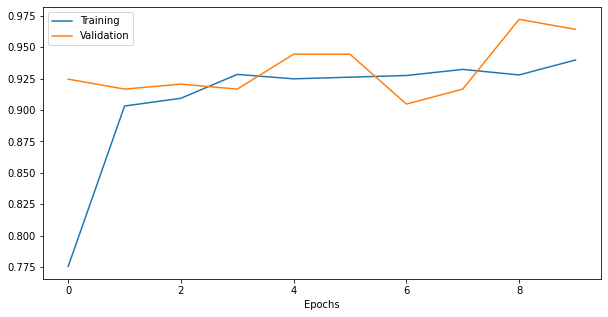

In [165]:
plt.figure(figsize=(10,5))
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epochs')

<h4>Rede Neural com dataset Assinatura</h4>

In [168]:
from sklearn.model_selection import train_test_split
X = signatures
Y = dados[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=84)

In [172]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


(3352, 59)

In [173]:
model = Sequential()
model.add(Dense(512, input_dim=59, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #Otimização do modelo

In [174]:
h = model.fit(X_train, y_train_cat, epochs=10, verbose=1, validation_split=0.1) #validation_data=(X_test, y_test_cat)

Epoch 1/10
71/71 [==============================] - 1s 11ms/step - loss: 1.3557 - accuracy: 0.6720 - val_loss: 0.2728 - val_accuracy: 0.8849
Epoch 2/10
71/71 [==============================] - 1s 8ms/step - loss: 0.2835 - accuracy: 0.8828 - val_loss: 0.2158 - val_accuracy: 0.8889
Epoch 3/10
71/71 [==============================] - 1s 8ms/step - loss: 0.2205 - accuracy: 0.9129 - val_loss: 0.1432 - val_accuracy: 0.9286
Epoch 4/10
71/71 [==============================] - 1s 8ms/step - loss: 0.1720 - accuracy: 0.9306 - val_loss: 0.1110 - val_accuracy: 0.9762
Epoch 5/10
71/71 [==============================] - 1s 8ms/step - loss: 0.1875 - accuracy: 0.9191 - val_loss: 0.1206 - val_accuracy: 0.9444
Epoch 6/10
71/71 [==============================] - 1s 8ms/step - loss: 0.1427 - accuracy: 0.9434 - val_loss: 0.0795 - val_accuracy: 0.9802
Epoch 7/10
71/71 [==============================] - 1s 8ms/step - loss: 0.1315 - accuracy: 0.9474 - val_loss: 0.0927 - val_accuracy: 0.9484
Epoch 8/10
71/71 [=

In [175]:
results = model.evaluate(X_test, y_test_cat)
print('Train: ', results[1])

27/27 [==============================] - 0s 3ms/step - loss: 0.0968 - accuracy: 0.9761
Train:  0.9761336445808411


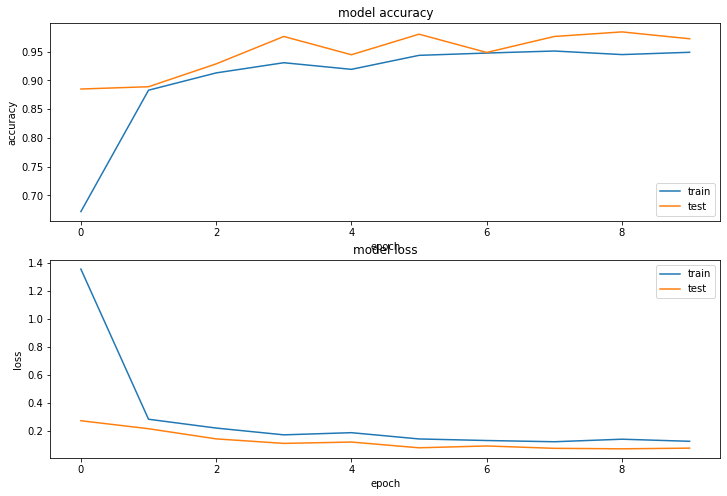

In [176]:
# plotting the metrics
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [81]:
X = chainCodes
y = dados[:,-1]

# Separando os dados de treino e teste:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=30)

In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Pipeline:
steps = [('scaler', StandardScaler()), ('SVM', SVC(kernel='poly'))]
pipeline = Pipeline(steps)

# Utilizando o GridSearchCV para o ajuste dos parâmetros:
parameters = {'SVM__C':[0.001, 0.1, 100, 10e5], 'SVM__gamma':[10,1,0.1,0.01]}
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)

# Treinando o modelo:
grid.fit(X_train, y_train)
print ("score = %3.2f" %(grid.score(X_test, y_test)))
print ("best parameters from train data: ", grid.best_params_)

score = 0.99
best parameters from train data:  {'SVM__C': 0.001, 'SVM__gamma': 1}


In [83]:
# Instanciando o algoritmo e passando os melhores parâmetros:
svc = SVC(C=0.001,gamma=10,kernel='poly')

In [84]:
# Treinando o modelo:
svc.fit(X_train,y_train)

# Realizando as predições:
resultado = svc.predict(X_test)

# Métricas de classificação:
from sklearn import metrics
print(metrics.classification_report(y_test,resultado))

              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90        59
         1.0       0.99      1.00      0.99        81
         2.0       1.00      1.00      1.00        54
         3.0       1.00      0.99      0.99        74
         4.0       1.00      0.99      0.99        82
         5.0       1.00      1.00      1.00        73
         6.0       1.00      1.00      1.00        79
         7.0       1.00      1.00      1.00        59
         8.0       0.91      0.89      0.90        56
         9.0       1.00      1.00      1.00        54

    accuracy                           0.98       671
   macro avg       0.98      0.98      0.98       671
weighted avg       0.98      0.98      0.98       671



In [85]:
# Matriz de confusão:
print (pd.crosstab(y_test,resultado, rownames=['Real'], colnames=['Predito'], margins=True))

Predito  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  All
Real                                                          
0.0       54    0    0    0    0    0    0    0    5    0   59
1.0        0   81    0    0    0    0    0    0    0    0   81
2.0        0    0   54    0    0    0    0    0    0    0   54
3.0        0    1    0   73    0    0    0    0    0    0   74
4.0        1    0    0    0   81    0    0    0    0    0   82
5.0        0    0    0    0    0   73    0    0    0    0   73
6.0        0    0    0    0    0    0   79    0    0    0   79
7.0        0    0    0    0    0    0    0   59    0    0   59
8.0        6    0    0    0    0    0    0    0   50    0   56
9.0        0    0    0    0    0    0    0    0    0   54   54
All       61   82   54   73   81   73   79   59   55   54  671


In [151]:
from sklearn.metrics import confusion_matrix

def pretty_confusion_matrix(y_true, y_pred, labels=['False','True']):
    cm = confusion_matrix(y_true, y_pred)
    pred_labels = ['Predicted '+ l for l in labels]
    df = pd.DataFrame(cm, index=labels, columns=pre_labels)
    return df


In [152]:
y_pred = model.predict(X_test) > 0.5

#cm = confusion_matrix(y_test_cat, y_pred)

#pretty_confusion_matrix(y_test_cat, y_pred, ['0', '1'])

In [153]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10, shuffle=True)

X = chainCodes
y = dados[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=84)

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train_cat, y_test_cat), axis=0)

acc_per_fold = []
loss_per_fold = []

fold_no = 1
for train, test in kfold.split(inputs, targets):
    model = Sequential()
    model.add(Dense(512, input_dim=67, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) #Otimização do modelo
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    #h = model.fit(X_train, y_train_cat, epochs=10, verbose=1, validation_split=0.3)
    history = model.fit(X_train, y_train_cat, epochs=10, verbose=1, validation_split=0.3)
    
    scores = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
55/55 [==============================] - 2s 10ms/step - loss: 1.2897 - accuracy: 0.5452 - val_loss: 0.5080 - val_accuracy: 0.8212
Epoch 2/10
55/55 [==============================] - 0s 6ms/step - loss: 0.3655 - accuracy: 0.8562 - val_loss: 0.2816 - val_accuracy: 0.8795
Epoch 3/10
55/55 [==============================] - 0s 7ms/step - loss: 0.2406 - accuracy: 0.8846 - val_loss: 0.2001 - val_accuracy: 0.8927
Epoch 4/10
55/55 [==============================] - 0s 6ms/step - loss: 0.1801 - accuracy: 0.9119 - val_loss: 0.1505 - val_accuracy: 0.9099
Epoch 5/10
55/55 [==============================] - 0s 6ms/step - loss: 0.1762 - accuracy: 0.9079 - val_loss: 0.1831 - val_accuracy: 0.9060
Epoch 6/10
55/55 [==============================] - 0s 6ms/step - loss: 0.1764 - accuracy: 0.9096 - val_loss: 0.1370 - val_accuracy: 0.9139
Epoch 7/10
55/55 [==============================] - 0s 7ms/ste

55/55 [==============================] - 0s 6ms/step - loss: 0.2780 - accuracy: 0.8749 - val_loss: 0.2067 - val_accuracy: 0.8940
Epoch 3/10
55/55 [==============================] - 0s 6ms/step - loss: 0.2098 - accuracy: 0.8931 - val_loss: 0.1817 - val_accuracy: 0.9020
Epoch 4/10
55/55 [==============================] - 0s 8ms/step - loss: 0.2003 - accuracy: 0.9039 - val_loss: 0.2344 - val_accuracy: 0.8927
Epoch 5/10
55/55 [==============================] - 0s 7ms/step - loss: 0.1652 - accuracy: 0.9056 - val_loss: 0.1287 - val_accuracy: 0.9219
Epoch 6/10
55/55 [==============================] - 0s 6ms/step - loss: 0.1837 - accuracy: 0.8994 - val_loss: 0.1265 - val_accuracy: 0.9126
Epoch 7/10
55/55 [==============================] - 0s 8ms/step - loss: 0.1824 - accuracy: 0.9022 - val_loss: 0.1244 - val_accuracy: 0.9205
Epoch 8/10
55/55 [==============================] - 0s 7ms/step - loss: 0.1574 - accuracy: 0.9068 - val_loss: 0.1338 - val_accuracy: 0.9113
Epoch 9/10
55/55 [=============